# Demo:  Gradient Descent Optimization

In the [breast cancer demo](../logistic/breast_cancer.ipynb), we used the `sklearn` built-in `LogisticRegression` class to find the weights for the logistic regression problem.   The `fit` routine in that class has an *optimizer* to select the weights to best match the data.  To understand how that optimizer works, in this demo, we will build a very simple gradient descent optimizer from scratch.  You will learn to:
* Compute the gradients of a simple loss function and implement the gradient calculations in python
* Implement a simple gradient descent optimizer
* Visualize the effect of the learning rate in gradient descent
* Implement an adaptive learning rate algorithm

## Loading the Breast Cancer Data

We first load the standard packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn import preprocessing

We next load the data from the [breast cancer demo](../logistic/breast_cancer.ipynb).  

In [2]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()
df.head()

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


As in the breast cancer demo, we create a data matrix `X` of various features of the breast cancer sample.  The response vector `y` is a binary indicating if each sample is benign or malignant.  

In [3]:
# Get the predictors
xnames = names[1:-1]
X = np.array(df[xnames])
Xs = preprocessing.scale(X)

# Get the response.  Convert to a zero-one indicator 
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int)

We want to learn the classification rule to predict `y` from `X`.  To this end, we first split the data into training and test.

In [4]:
ntr = 400        # number of training samples
Xtr = X[:ntr,:]  # training
ytr = y[:ntr]
Xts = X[ntr:,:]  # test
yts = y[ntr:]

## Computing the Gradient and Loss Function

Recall that training a logistic function means finding a weight vector `w` for the classification rule:

$$
    Pr\{y=1|\boldsymbol{x},\boldsymbol{w}\} = \frac{1}{1+e^{-z}}, \quad z = w_0 + \sum_{j=1}^d x_j w_j
$$    
Note that we use $w_0$ for the intercept term rather than $b$ to simplify the notation. 
From the class notes on logistic regression, we saw that the weight vector is optimized by minimizing the negative log-likelihood. By doing so, we are choosing the *loss* function, i.e., the quantity that we minimize to fit our model parameters, to be the negative log-likelihood.  For logistic regression with $y\in\{0,1\}$, the lecture derived that negative log-likelihood loss can be written as:

$$
    J(\boldsymbol{w}) 
    \triangleq - \ln p(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w}) 
    = \sum_i \left[ \ln(1+e^{z_i}) -y_i z_i \right],  \quad z_i = w_0 + \sum_{j=1}^d x_{ij} w_j.
$$

To run a numerical optimizer in python, we need to implement a python function that returns `J(w)` and its gradient.  That is, we would like a function of the form:

    def Jeval(w):
        ...
        return J, Jgrad

One issue is that the function `J(w)` also depends parameters `X` and `y`.  So, we need a way to pass those parameters to the function.  Below we outline two approaches. The first builds `J(w,X,y)` and then wraps in inside a *lambda* function `J(w)` that fixes the values of `X,y`. The second constructs a *class* that contains the parameters `X,y` as well as a method `J(w)` that has access to `X,y`.

For use in the future, we will first draw a random `w` vector.

In [5]:
# numpy-recommended way to create random number generator
# https://numpy.org/doc/stable/reference/random/generator.html
rng = np.random.default_rng(0)

# Draw a random vector w0
d = X.shape[1]
w0 = rng.standard_normal(d+1)

### Method 1.  Construct a "lambda" function

A simple method is to construct a python *lambda function*, which is simply a function that is defined using a single line of code.  In Matlab they are called *anonymous functions*.  The code below first creates a regular function `Jeval_param` that takes in all the parameters.  Next, it creates a lambda function called `Jeval(w)` that contains fixed values of the parameters `Xtr` and `ytr`.  Finally, it calls the lambda function with the input `w0`.

In [6]:
# First create a function with all the parameters

def Jeval_param(w,X,y):
        """
        Compute the loss and gradient of w given w,X,y
        """
        # Construct transform matrix
        n = X.shape[0]
        A = np.column_stack((np.ones(n,), X))
        
        # The loss is the binary cross entropy
        z = A.dot(w)
        py = 1/(1+np.exp(-z))
        J = np.sum((1-y)*z - np.log(py))
        
        # Gradient
        df_dz = py-y
        Jgrad = A.T.dot(df_dz)
        return J, Jgrad

# Then create a function with fixed X,y
Jeval = lambda w: Jeval_param(w,Xtr,ytr)

# Evaluate J and Jgrad at w0
J0, Jgrad0 = Jeval(w0)

### Method 2.  Construct a "class"

A much more powerful approach is to construct a *class* that contains the parameters as internal attributes as well as a *method* `Jeval(w)` that has access to those internal attributes.  All classes must have a *constructor* method that is run by default when the class is instantiated.  The constructor method loads in the parameters `X,y` and makes them attributes of the class. Then these internal attributes are accessed using `self.`. Below, we create a class called `LogisticFun`, instantiate it at `log_fun` using `Xtr,ytr`, and finall call the `Jeval` method in `log_fun`.

In [7]:
# Construct a class to compute loss & gradient for binary logistic regression

class LogisticFun(object):
    def __init__(self,X,y):
        """
        The constructor takes in the training features `X` and responses y
        """
        self.X = X
        self.y = y
        n = X.shape[0]
        self.A = np.column_stack((np.ones(n,), X))

    def Jeval(self,w):
        """
        The Jeval method computes the loss and gradient at weights w
        """
        # The loss is the binary cross entropy
        z = self.A.dot(w)
        py = 1/(1+np.exp(-z))
        J = np.sum((1-self.y)*z - np.log(py))
        
        # Gradient
        df_dz = py-self.y
        Jgrad = self.A.T.dot(df_dz)
        return J, Jgrad

# Instantiate the class
log_fun = LogisticFun(Xtr,ytr)

# Call the method
J0, Jgrad0 = log_fun.Jeval(w0)

### Testing the gradient

Regardess of how the function is constructed, it is very important to verify that the gradient is correct.  This is the primary reason that code fails with numerical optimizers.  The simplest way to verify the gradient is to take two points `w0` and `w1` that are close to one another and then verify that 

    J(w1) - J(w0) \approx Jgrad(w0).dot(w1 - w0)

In [8]:
# Take a random initial point
d = X.shape[1]
w0 = rng.standard_normal(d+1)

# Perturb the point
step = 1e-6
w1 = w0 + step*rng.standard_normal(d+1)

# Measure the function and gradient at w0 and w1
J0, Jgrad0 = log_fun.Jeval(w0)
J1, Jgrad1 = log_fun.Jeval(w1)

# Predict the amount the function should have changed based on the gradient
dJ_pred = Jgrad0.dot(w1-w0)

# Print the two values to see if they are close
print("Actual J1-J0    = %12.4e" % (J1-J0))
print("Predicted J1-J0 = %12.4e" % dJ_pred)

Actual J1-J0    =  -5.9502e-05
Predicted J1-J0 =  -5.9502e-05


You can see that the two values agree well.  You would have got the same answer had you used the `Jeval` lambda function that we constructed earlier.

## A Simple Gradient Descent Optimizer

Now, we build a simple gradient descent optimizer function with a fixed learning rate.

In [9]:
def grad_opt_simp(Jeval, winit, lr=1e-3, nit=1000):
    """
    Simple gradient descent optimization
    
    Jeval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    lr:     learning rate
    nit:    Number of iterations
    """
    # Initialize
    w0 = winit
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'w': [], 'J': []}
    
    # Loop over iterations
    for it in range(nit):

        # Evaluate the function and gradient
        J0, Jgrad0 = Jeval(w0)

        # Take a gradient step
        w0 = w0 - lr*Jgrad0
        
         # Save history
        hist['J'].append(J0)
        hist['w'].append(w0)

    # Convert to numpy arrays
    for elem in ('J', 'w'):
        hist[elem] = np.array(hist[elem])
        
    return w0, J0, hist

We now run the gradient descent starting from a random initial condition and plot the loss trajectory on a log-log scale.

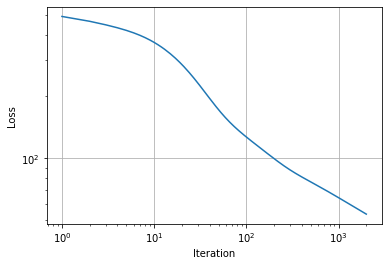

In [10]:
# Initial condition
winit = rng.standard_normal(d+1)

# Parameters
Jeval = log_fun.Jeval
nit = 2000
lr = 1e-4

# Run the gradient descent
w, J0, hist = grad_opt_simp(Jeval, winit, lr=lr, nit=nit)

# Plot the training loss
t = 1+np.arange(nit)
plt.loglog(t, hist['J'])
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Iteration');

We can measure the test accuracy of the final parameters using a `predict` function.

In [11]:
def predict(X,w):
    z = X.dot(w[1:]) + w[0]
    yhat = (z > 0)
    return yhat

yhat = predict(Xts,w)
acc = np.mean(yhat == yts)
print("Loss = %6.2f, Test accuracy = %6.4f" % (J0,acc))

Loss =  53.56, Test accuracy = 0.9859


This is not quite as good as the test accuracy for the `sklearn` Logistic Regression method.  The loss-vs-iteration plot suggests that we didn't fully converge after `nit` iterations.

Let's see whether we can improve performance using a different learning rate.

lr= 1.00e-05, Loss =  99.58, Test accuracy = 0.9187
lr= 1.00e-04, Loss =  53.56, Test accuracy = 0.9859
lr= 1.00e-03, Loss =  39.68, Test accuracy = 0.9894
lr= 2.00e-03, Loss =  51.46, Test accuracy = 0.9859


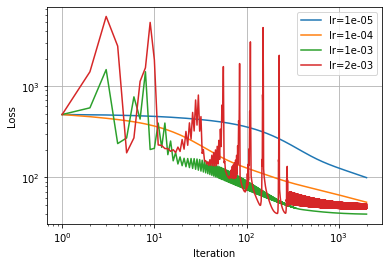

In [12]:
# Learning rate values to test
lr_test = [1e-5,1e-4,1e-3,2e-3]
ntest = len(lr_test)

# Strings for the legend
leg_str = []

for i, lr in enumerate(lr_test):
    # Run the optimizer
    w, J0, hist = grad_opt_simp(Jeval, winit, lr=lr, nit=nit)    
    
    # Plot the results
    plt.loglog(t, hist['J'])
    leg_str.append("lr=%5.0e" % lr)
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    
    # Measure the test accuracy
    yhat = predict(Xts,w)
    acc = np.mean(yhat == yts)
    print("lr=%9.2e, Loss = %6.2f, Test accuracy = %6.4f" % (lr, J0, acc))
    
plt.grid()
plt.legend(leg_str, loc='upper right');

We see that increasing the learning rate helps to speed up the convergence rate up to 1e-3, but further increases in the learning rate result in an optimization trajectory that looks rough and a final loss value that is suboptimal.

## Adaptive Step-Size

The above example shows that gradient descent is sensitive to the step size.  We now consider a variant of gradient descent with an *adaptive* step-size adjustment that is based on the Armijo rule discussed in the lecture.

In [28]:
def grad_opt_adapt(Jeval, winit, nit=1000, lr_init=1e-3, beta_incr=1.05, beta_decr=0.5, c=0.5):
    """
    Gradient descent optimization with Armijo adaptive step size
    
    Jeval:  A function that returns J, Jgrad, the objective
            function and its gradient
    winit:  Initial estimate
    nit:    Number of iterations
    lr:     Initial learning rate
    """

    # Set initial point
    w0 = winit
    J0, Jgrad0 = Jeval(w0)
    lr = lr_init
    
    # Create history dictionary for tracking progress per iteration.
    hist = {'w': [], 'J': [], 'lr': []}

    # Save history
    hist['w'].append(w0)
    hist['J'].append(J0)
    hist['lr'].append(lr)
    
    # Loop over GD iterations
    for it in range(nit):

        # Take a gradient step
        w1 = w0 - lr*Jgrad0
        J1, Jgrad1 = Jeval(w1)
        
        # Check if update passes the Armijo condition
        if (J1 < J0 - c*lr*np.linalg.norm(Jgrad0)**2):
            # If passes...
            w0 = w1 # accept the update
            J0 = J1 # accept the update
            Jgrad0 = Jgrad1 # accept the update
            lr = lr*beta_incr # increase learning rate
        else:
            # If fails...
            lr = lr*beta_decr # decrease learning rate
        
        # Save history
        hist['w'].append(w0)
        hist['J'].append(J0)
        hist['lr'].append(lr)
        
    # Convert dictionary to numpy arrays
    for elem in ('w', 'J', 'lr'):
        hist[elem] = np.array(hist[elem])
        
    return w0, J0, hist


We can now run our new optimizer.

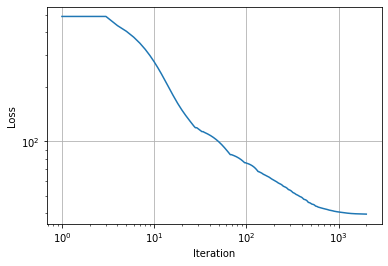

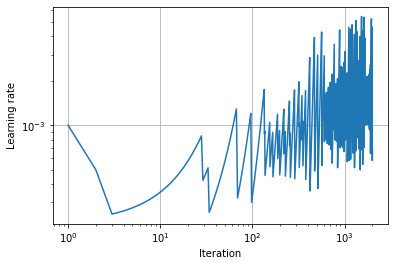

In [29]:
w, J0, hist = grad_opt_adapt(Jeval, winit, nit=nit)

t = 1+np.arange(nit+1)
plt.loglog(t, hist['J'])
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

plt.loglog(t, hist['lr'])
plt.grid()
plt.ylabel('Learning rate')
plt.xlabel('Iteration');


We now measure the Armijo method's final loss and test accuracy.

In [30]:
yhat = predict(Xts,w)
acc = np.mean(yhat == yts)
print("Loss = %6.2f, Test accuracy = %6.4f" % (J0,acc))

Loss =  39.55, Test accuracy = 0.9894


We see that the adaptive-stepsize technique achieves slightly lower loss than the best fixed-stepsize technique, and equal test accuracy.